## 데이터 로드

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


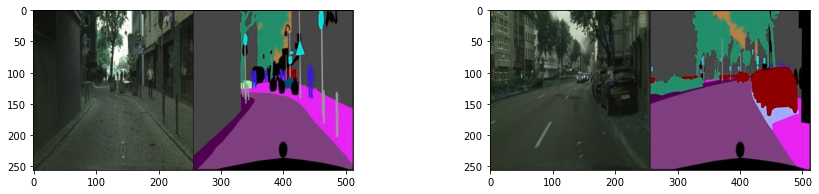

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
for i in range(1, 3):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 2개 이미지로 분할

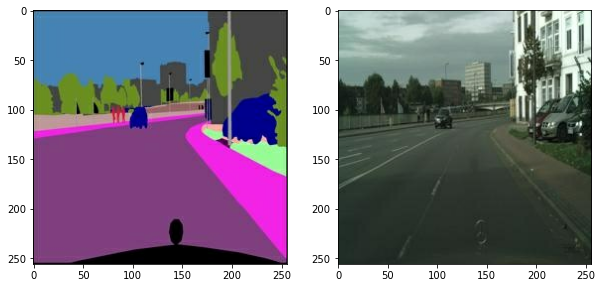

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)

f = data_path + os.listdir(data_path)[1]
colored, sketch = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## 데이터 분석
* 하나의 train dataset은 세그멘테이션 이미지와 실제 이미지로 구성되어 있다. 세그멘테이션 이미지는 sketch라는 변수에, 실제 이미지는 colored 라는 변수에 넣기로 했다. 이 세그멘테이션 이미지를 cGAN을 사용하여 실제 이미지처럼 만들어야 한다. 

## 여러 augmentation 방법을 적용

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.

1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다. (tf.pad)

2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop) 

3.의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)

4.의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down) 

5.의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)

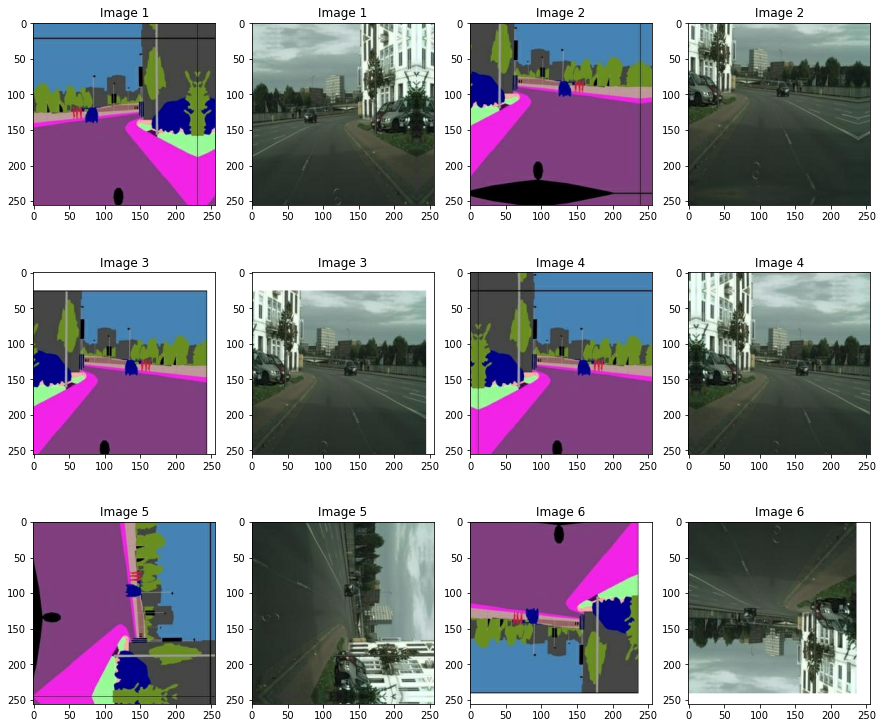

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

* sketch ,colored분리 함수 구현

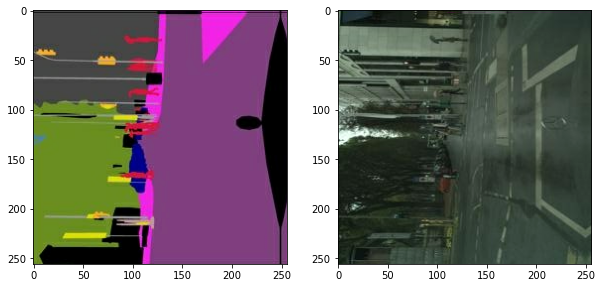

In [7]:
from tensorflow import data

def get_train(img_path):
    colored,sketch  = load_img(img_path)
    colored,sketch  = apply_augmentation(sketch, colored)
    return colored, sketch 

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch ,colored= (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Generator 구현하기

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


## Encoder 구성

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

## Decoder를 구현

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

## Encoder와 Decoder를 연결해 Generator를 구성

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


 ## Generator는 위 그림의 Encoder-decoder 구조
 ## U-Net 구조를 만들고 실험

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


## U-Net Generator를 정의

In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## Discriminator 구현하기

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

* 시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보았다.

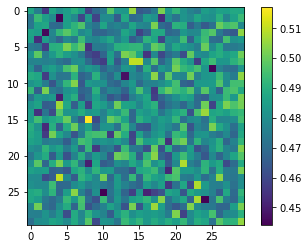

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈다. 그래서 두 가지 손실 함수를 모두 사용해 보았다.

In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


* optimizer는 논문과 동일하게 아래와 같이 설정

In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


* 학습

In [25]:
EPOCHS = 150

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        #plt.title('sketch')
        #plt.imshow(sketch[0])
        #plt.title('colored')
        #plt.imshow(colored[0])
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8444                     
L1_loss:0.3498                     
Discriminator_loss:1.3240

EPOCH[1] - STEP[20]                     
Generator_loss:0.8583                     
L1_loss:0.2393                     
Discriminator_loss:1.2096

EPOCH[1] - STEP[30]                     
Generator_loss:1.0415                     
L1_loss:0.2192                     
Discriminator_loss:1.3653

EPOCH[1] - STEP[40]                     
Generator_loss:0.9472                     
L1_loss:0.2066                     
Discriminator_loss:1.2669

EPOCH[1] - STEP[50]                     
Generator_loss:0.9975                     
L1_loss:0.1984                     
Discriminator_loss:1.3193

EPOCH[1] - STEP[60]                     
Generator_loss:0.9037                     
L1_loss:0.1673                     
Discriminator_loss:1.1378

EPOCH[1] - STEP[70]                     
Generator_loss:1.4521                     
L1_loss:0.1791                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.3847                     
L1_loss:0.1825                     
Discriminator_loss:1.5777

EPOCH[3] - STEP[80]                     
Generator_loss:1.0655                     
L1_loss:0.1731                     
Discriminator_loss:0.9823

EPOCH[3] - STEP[90]                     
Generator_loss:0.5840                     
L1_loss:0.1799                     
Discriminator_loss:1.2979

EPOCH[3] - STEP[100]                     
Generator_loss:1.0951                     
L1_loss:0.1959                     
Discriminator_loss:0.8785

EPOCH[3] - STEP[110]                     
Generator_loss:1.3560                     
L1_loss:0.1957                     
Discriminator_loss:0.3961

EPOCH[3] - STEP[120]                     
Generator_loss:0.7287                     
L1_loss:0.1698                     
Discriminator_loss:1.3735

EPOCH[3] - STEP[130]                     
Generator_loss:1.9193                     
L1_loss:0.2183                

EPOCH[5] - STEP[130]                     
Generator_loss:0.8827                     
L1_loss:0.1994                     
Discriminator_loss:1.0305

EPOCH[5] - STEP[140]                     
Generator_loss:0.9657                     
L1_loss:0.2301                     
Discriminator_loss:0.9521

EPOCH[5] - STEP[150]                     
Generator_loss:1.5304                     
L1_loss:0.1738                     
Discriminator_loss:0.5076

EPOCH[5] - STEP[160]                     
Generator_loss:2.8649                     
L1_loss:0.1897                     
Discriminator_loss:0.5139

EPOCH[5] - STEP[170]                     
Generator_loss:2.0914                     
L1_loss:0.2252                     
Discriminator_loss:0.4824

EPOCH[5] - STEP[180]                     
Generator_loss:2.6738                     
L1_loss:0.1458                     
Discriminator_loss:1.2254

EPOCH[5] - STEP[190]                     
Generator_loss:1.9401                     
L1_loss:0.1723             

EPOCH[7] - STEP[190]                     
Generator_loss:1.3214                     
L1_loss:0.1785                     
Discriminator_loss:0.7291

EPOCH[7] - STEP[200]                     
Generator_loss:1.8445                     
L1_loss:0.2017                     
Discriminator_loss:0.8446

EPOCH[7] - STEP[210]                     
Generator_loss:1.8072                     
L1_loss:0.1557                     
Discriminator_loss:1.0103

EPOCH[7] - STEP[220]                     
Generator_loss:1.3539                     
L1_loss:0.1746                     
Discriminator_loss:0.5535

EPOCH[7] - STEP[230]                     
Generator_loss:1.1674                     
L1_loss:0.1502                     
Discriminator_loss:0.6579

EPOCH[7] - STEP[240]                     
Generator_loss:1.4945                     
L1_loss:0.1920                     
Discriminator_loss:0.4344

EPOCH[7] - STEP[250]                     
Generator_loss:1.2688                     
L1_loss:0.1827             

EPOCH[9] - STEP[250]                     
Generator_loss:0.6333                     
L1_loss:0.1515                     
Discriminator_loss:1.2265

EPOCH[10] - STEP[10]                     
Generator_loss:0.5036                     
L1_loss:0.1759                     
Discriminator_loss:1.2298

EPOCH[10] - STEP[20]                     
Generator_loss:1.5989                     
L1_loss:0.1827                     
Discriminator_loss:0.5831

EPOCH[10] - STEP[30]                     
Generator_loss:0.9811                     
L1_loss:0.2209                     
Discriminator_loss:0.5375

EPOCH[10] - STEP[40]                     
Generator_loss:1.3140                     
L1_loss:0.2063                     
Discriminator_loss:0.5571

EPOCH[10] - STEP[50]                     
Generator_loss:1.6656                     
L1_loss:0.2056                     
Discriminator_loss:0.9219

EPOCH[10] - STEP[60]                     
Generator_loss:1.5309                     
L1_loss:0.1767             

EPOCH[12] - STEP[60]                     
Generator_loss:0.9779                     
L1_loss:0.2190                     
Discriminator_loss:0.6879

EPOCH[12] - STEP[70]                     
Generator_loss:1.0160                     
L1_loss:0.1646                     
Discriminator_loss:0.8128

EPOCH[12] - STEP[80]                     
Generator_loss:1.1663                     
L1_loss:0.1743                     
Discriminator_loss:0.6824

EPOCH[12] - STEP[90]                     
Generator_loss:0.7806                     
L1_loss:0.1834                     
Discriminator_loss:0.8214

EPOCH[12] - STEP[100]                     
Generator_loss:1.8751                     
L1_loss:0.2062                     
Discriminator_loss:0.2808

EPOCH[12] - STEP[110]                     
Generator_loss:1.4511                     
L1_loss:0.2221                     
Discriminator_loss:0.5598

EPOCH[12] - STEP[120]                     
Generator_loss:0.8946                     
L1_loss:0.1656          

EPOCH[14] - STEP[120]                     
Generator_loss:1.0871                     
L1_loss:0.1851                     
Discriminator_loss:0.6989

EPOCH[14] - STEP[130]                     
Generator_loss:1.6359                     
L1_loss:0.2145                     
Discriminator_loss:0.2745

EPOCH[14] - STEP[140]                     
Generator_loss:1.4896                     
L1_loss:0.1762                     
Discriminator_loss:0.3590

EPOCH[14] - STEP[150]                     
Generator_loss:1.0741                     
L1_loss:0.1750                     
Discriminator_loss:1.2213

EPOCH[14] - STEP[160]                     
Generator_loss:1.4764                     
L1_loss:0.1710                     
Discriminator_loss:0.7308

EPOCH[14] - STEP[170]                     
Generator_loss:0.6211                     
L1_loss:0.1990                     
Discriminator_loss:0.9589

EPOCH[14] - STEP[180]                     
Generator_loss:1.4490                     
L1_loss:0.1758      

EPOCH[16] - STEP[180]                     
Generator_loss:1.5957                     
L1_loss:0.2051                     
Discriminator_loss:0.4405

EPOCH[16] - STEP[190]                     
Generator_loss:1.8872                     
L1_loss:0.1637                     
Discriminator_loss:1.2188

EPOCH[16] - STEP[200]                     
Generator_loss:1.3722                     
L1_loss:0.1770                     
Discriminator_loss:0.6709

EPOCH[16] - STEP[210]                     
Generator_loss:2.8439                     
L1_loss:0.1820                     
Discriminator_loss:2.2740

EPOCH[16] - STEP[220]                     
Generator_loss:2.6591                     
L1_loss:0.1824                     
Discriminator_loss:1.2745

EPOCH[16] - STEP[230]                     
Generator_loss:0.8499                     
L1_loss:0.1705                     
Discriminator_loss:1.0689

EPOCH[16] - STEP[240]                     
Generator_loss:0.5424                     
L1_loss:0.1902      

EPOCH[18] - STEP[240]                     
Generator_loss:3.0472                     
L1_loss:0.1852                     
Discriminator_loss:0.6321

EPOCH[18] - STEP[250]                     
Generator_loss:0.5916                     
L1_loss:0.1897                     
Discriminator_loss:0.9972

EPOCH[19] - STEP[10]                     
Generator_loss:1.3769                     
L1_loss:0.2199                     
Discriminator_loss:0.3450

EPOCH[19] - STEP[20]                     
Generator_loss:2.2870                     
L1_loss:0.1810                     
Discriminator_loss:0.5397

EPOCH[19] - STEP[30]                     
Generator_loss:1.3022                     
L1_loss:0.1620                     
Discriminator_loss:0.6308

EPOCH[19] - STEP[40]                     
Generator_loss:0.9953                     
L1_loss:0.1564                     
Discriminator_loss:1.2208

EPOCH[19] - STEP[50]                     
Generator_loss:1.5967                     
L1_loss:0.1950           

EPOCH[21] - STEP[50]                     
Generator_loss:0.6350                     
L1_loss:0.1894                     
Discriminator_loss:0.8706

EPOCH[21] - STEP[60]                     
Generator_loss:1.2097                     
L1_loss:0.1770                     
Discriminator_loss:0.5961

EPOCH[21] - STEP[70]                     
Generator_loss:1.6584                     
L1_loss:0.2199                     
Discriminator_loss:0.2883

EPOCH[21] - STEP[80]                     
Generator_loss:2.0111                     
L1_loss:0.1634                     
Discriminator_loss:0.8397

EPOCH[21] - STEP[90]                     
Generator_loss:1.4325                     
L1_loss:0.1662                     
Discriminator_loss:0.8270

EPOCH[21] - STEP[100]                     
Generator_loss:2.4275                     
L1_loss:0.2085                     
Discriminator_loss:0.1216

EPOCH[21] - STEP[110]                     
Generator_loss:2.1598                     
L1_loss:0.1839           

EPOCH[23] - STEP[110]                     
Generator_loss:1.0623                     
L1_loss:0.1727                     
Discriminator_loss:0.9346

EPOCH[23] - STEP[120]                     
Generator_loss:2.0234                     
L1_loss:0.2033                     
Discriminator_loss:0.2467

EPOCH[23] - STEP[130]                     
Generator_loss:0.4058                     
L1_loss:0.1782                     
Discriminator_loss:1.4290

EPOCH[23] - STEP[140]                     
Generator_loss:1.9859                     
L1_loss:0.2019                     
Discriminator_loss:0.4373

EPOCH[23] - STEP[150]                     
Generator_loss:1.2967                     
L1_loss:0.2154                     
Discriminator_loss:0.4062

EPOCH[23] - STEP[160]                     
Generator_loss:1.1971                     
L1_loss:0.1545                     
Discriminator_loss:1.1964

EPOCH[23] - STEP[170]                     
Generator_loss:0.9448                     
L1_loss:0.1766      

EPOCH[25] - STEP[170]                     
Generator_loss:0.6233                     
L1_loss:0.1607                     
Discriminator_loss:1.5339

EPOCH[25] - STEP[180]                     
Generator_loss:0.6312                     
L1_loss:0.2416                     
Discriminator_loss:0.9587

EPOCH[25] - STEP[190]                     
Generator_loss:1.6773                     
L1_loss:0.1713                     
Discriminator_loss:1.0281

EPOCH[25] - STEP[200]                     
Generator_loss:1.1090                     
L1_loss:0.1810                     
Discriminator_loss:0.5612

EPOCH[25] - STEP[210]                     
Generator_loss:0.8825                     
L1_loss:0.1809                     
Discriminator_loss:0.6727

EPOCH[25] - STEP[220]                     
Generator_loss:1.0715                     
L1_loss:0.1659                     
Discriminator_loss:0.8959

EPOCH[25] - STEP[230]                     
Generator_loss:2.1250                     
L1_loss:0.2242      

EPOCH[27] - STEP[230]                     
Generator_loss:1.2338                     
L1_loss:0.1651                     
Discriminator_loss:0.7958

EPOCH[27] - STEP[240]                     
Generator_loss:1.8232                     
L1_loss:0.1736                     
Discriminator_loss:0.7016

EPOCH[27] - STEP[250]                     
Generator_loss:0.7417                     
L1_loss:0.1766                     
Discriminator_loss:1.3557

EPOCH[28] - STEP[10]                     
Generator_loss:0.6163                     
L1_loss:0.2465                     
Discriminator_loss:1.0407

EPOCH[28] - STEP[20]                     
Generator_loss:1.3318                     
L1_loss:0.1893                     
Discriminator_loss:0.5919

EPOCH[28] - STEP[30]                     
Generator_loss:2.0539                     
L1_loss:0.1800                     
Discriminator_loss:1.6362

EPOCH[28] - STEP[40]                     
Generator_loss:1.1005                     
L1_loss:0.1712          

EPOCH[30] - STEP[40]                     
Generator_loss:1.1467                     
L1_loss:0.2332                     
Discriminator_loss:0.4522

EPOCH[30] - STEP[50]                     
Generator_loss:2.8496                     
L1_loss:0.2220                     
Discriminator_loss:0.2412

EPOCH[30] - STEP[60]                     
Generator_loss:0.9656                     
L1_loss:0.1772                     
Discriminator_loss:0.6102

EPOCH[30] - STEP[70]                     
Generator_loss:0.8335                     
L1_loss:0.1513                     
Discriminator_loss:0.9923

EPOCH[30] - STEP[80]                     
Generator_loss:1.0201                     
L1_loss:0.2022                     
Discriminator_loss:0.5880

EPOCH[30] - STEP[90]                     
Generator_loss:1.3810                     
L1_loss:0.1719                     
Discriminator_loss:0.6410

EPOCH[30] - STEP[100]                     
Generator_loss:1.4997                     
L1_loss:0.1906            

EPOCH[32] - STEP[100]                     
Generator_loss:2.2243                     
L1_loss:0.1676                     
Discriminator_loss:0.7988

EPOCH[32] - STEP[110]                     
Generator_loss:2.0146                     
L1_loss:0.1438                     
Discriminator_loss:1.2258

EPOCH[32] - STEP[120]                     
Generator_loss:0.8663                     
L1_loss:0.1764                     
Discriminator_loss:0.8443

EPOCH[32] - STEP[130]                     
Generator_loss:1.5974                     
L1_loss:0.1942                     
Discriminator_loss:0.4348

EPOCH[32] - STEP[140]                     
Generator_loss:0.9680                     
L1_loss:0.1875                     
Discriminator_loss:0.5741

EPOCH[32] - STEP[150]                     
Generator_loss:1.7111                     
L1_loss:0.1425                     
Discriminator_loss:0.8436

EPOCH[32] - STEP[160]                     
Generator_loss:1.2708                     
L1_loss:0.1803      

EPOCH[34] - STEP[160]                     
Generator_loss:1.0870                     
L1_loss:0.1566                     
Discriminator_loss:2.4986

EPOCH[34] - STEP[170]                     
Generator_loss:0.8764                     
L1_loss:0.1942                     
Discriminator_loss:0.8959

EPOCH[34] - STEP[180]                     
Generator_loss:2.1337                     
L1_loss:0.1811                     
Discriminator_loss:2.4521

EPOCH[34] - STEP[190]                     
Generator_loss:0.8834                     
L1_loss:0.1711                     
Discriminator_loss:1.0513

EPOCH[34] - STEP[200]                     
Generator_loss:1.7690                     
L1_loss:0.1798                     
Discriminator_loss:0.4865

EPOCH[34] - STEP[210]                     
Generator_loss:1.6378                     
L1_loss:0.2030                     
Discriminator_loss:0.6138

EPOCH[34] - STEP[220]                     
Generator_loss:1.0327                     
L1_loss:0.1848      

EPOCH[36] - STEP[220]                     
Generator_loss:1.5904                     
L1_loss:0.1989                     
Discriminator_loss:0.3947

EPOCH[36] - STEP[230]                     
Generator_loss:2.7693                     
L1_loss:0.1556                     
Discriminator_loss:1.2577

EPOCH[36] - STEP[240]                     
Generator_loss:2.8394                     
L1_loss:0.1552                     
Discriminator_loss:2.1399

EPOCH[36] - STEP[250]                     
Generator_loss:1.4878                     
L1_loss:0.1727                     
Discriminator_loss:0.4218

EPOCH[37] - STEP[10]                     
Generator_loss:1.0474                     
L1_loss:0.1882                     
Discriminator_loss:0.5774

EPOCH[37] - STEP[20]                     
Generator_loss:1.3921                     
L1_loss:0.1770                     
Discriminator_loss:0.7176

EPOCH[37] - STEP[30]                     
Generator_loss:0.7873                     
L1_loss:0.1926         

EPOCH[39] - STEP[30]                     
Generator_loss:0.9114                     
L1_loss:0.1827                     
Discriminator_loss:0.7684

EPOCH[39] - STEP[40]                     
Generator_loss:0.8237                     
L1_loss:0.1668                     
Discriminator_loss:0.7387

EPOCH[39] - STEP[50]                     
Generator_loss:1.2980                     
L1_loss:0.2098                     
Discriminator_loss:0.3857

EPOCH[39] - STEP[60]                     
Generator_loss:1.5598                     
L1_loss:0.1591                     
Discriminator_loss:1.9921

EPOCH[39] - STEP[70]                     
Generator_loss:0.9633                     
L1_loss:0.1378                     
Discriminator_loss:1.3237

EPOCH[39] - STEP[80]                     
Generator_loss:1.3343                     
L1_loss:0.1500                     
Discriminator_loss:0.8547

EPOCH[39] - STEP[90]                     
Generator_loss:0.4593                     
L1_loss:0.1699             

EPOCH[41] - STEP[90]                     
Generator_loss:2.6574                     
L1_loss:0.1767                     
Discriminator_loss:0.8913

EPOCH[41] - STEP[100]                     
Generator_loss:1.3295                     
L1_loss:0.1792                     
Discriminator_loss:0.7832

EPOCH[41] - STEP[110]                     
Generator_loss:1.5772                     
L1_loss:0.1666                     
Discriminator_loss:0.8526

EPOCH[41] - STEP[120]                     
Generator_loss:2.1334                     
L1_loss:0.1999                     
Discriminator_loss:0.2342

EPOCH[41] - STEP[130]                     
Generator_loss:0.3010                     
L1_loss:0.1747                     
Discriminator_loss:1.7645

EPOCH[41] - STEP[140]                     
Generator_loss:1.9966                     
L1_loss:0.1566                     
Discriminator_loss:0.8216

EPOCH[41] - STEP[150]                     
Generator_loss:1.1923                     
L1_loss:0.1825       

EPOCH[43] - STEP[150]                     
Generator_loss:1.3034                     
L1_loss:0.1855                     
Discriminator_loss:1.0910

EPOCH[43] - STEP[160]                     
Generator_loss:2.1528                     
L1_loss:0.1731                     
Discriminator_loss:0.3608

EPOCH[43] - STEP[170]                     
Generator_loss:1.4459                     
L1_loss:0.1681                     
Discriminator_loss:1.8775

EPOCH[43] - STEP[180]                     
Generator_loss:0.4832                     
L1_loss:0.2052                     
Discriminator_loss:1.2001

EPOCH[43] - STEP[190]                     
Generator_loss:1.9878                     
L1_loss:0.1603                     
Discriminator_loss:0.5251

EPOCH[43] - STEP[200]                     
Generator_loss:0.4640                     
L1_loss:0.1726                     
Discriminator_loss:1.7656

EPOCH[43] - STEP[210]                     
Generator_loss:2.1611                     
L1_loss:0.1648      

EPOCH[45] - STEP[210]                     
Generator_loss:1.8481                     
L1_loss:0.1848                     
Discriminator_loss:1.2952

EPOCH[45] - STEP[220]                     
Generator_loss:1.9033                     
L1_loss:0.1807                     
Discriminator_loss:0.9428

EPOCH[45] - STEP[230]                     
Generator_loss:2.0002                     
L1_loss:0.1908                     
Discriminator_loss:1.9776

EPOCH[45] - STEP[240]                     
Generator_loss:1.1201                     
L1_loss:0.1533                     
Discriminator_loss:0.9360

EPOCH[45] - STEP[250]                     
Generator_loss:0.8269                     
L1_loss:0.1555                     
Discriminator_loss:0.8887

EPOCH[46] - STEP[10]                     
Generator_loss:1.9284                     
L1_loss:0.1562                     
Discriminator_loss:0.8346

EPOCH[46] - STEP[20]                     
Generator_loss:0.8642                     
L1_loss:0.1818        

EPOCH[48] - STEP[20]                     
Generator_loss:1.8005                     
L1_loss:0.1751                     
Discriminator_loss:0.6787

EPOCH[48] - STEP[30]                     
Generator_loss:1.1321                     
L1_loss:0.1697                     
Discriminator_loss:0.6849

EPOCH[48] - STEP[40]                     
Generator_loss:1.3902                     
L1_loss:0.1571                     
Discriminator_loss:0.9476

EPOCH[48] - STEP[50]                     
Generator_loss:0.7386                     
L1_loss:0.1639                     
Discriminator_loss:1.0886

EPOCH[48] - STEP[60]                     
Generator_loss:2.3032                     
L1_loss:0.1419                     
Discriminator_loss:0.9218

EPOCH[48] - STEP[70]                     
Generator_loss:1.3033                     
L1_loss:0.1744                     
Discriminator_loss:1.6000

EPOCH[48] - STEP[80]                     
Generator_loss:0.6141                     
L1_loss:0.1880             

EPOCH[50] - STEP[80]                     
Generator_loss:1.3386                     
L1_loss:0.1724                     
Discriminator_loss:1.4225

EPOCH[50] - STEP[90]                     
Generator_loss:1.8996                     
L1_loss:0.1868                     
Discriminator_loss:0.5315

EPOCH[50] - STEP[100]                     
Generator_loss:1.0958                     
L1_loss:0.1544                     
Discriminator_loss:2.0315

EPOCH[50] - STEP[110]                     
Generator_loss:0.4960                     
L1_loss:0.1733                     
Discriminator_loss:1.2519

EPOCH[50] - STEP[120]                     
Generator_loss:2.9808                     
L1_loss:0.1797                     
Discriminator_loss:0.4616

EPOCH[50] - STEP[130]                     
Generator_loss:2.2827                     
L1_loss:0.1604                     
Discriminator_loss:0.7833

EPOCH[50] - STEP[140]                     
Generator_loss:0.4927                     
L1_loss:0.2170        

EPOCH[52] - STEP[140]                     
Generator_loss:0.7491                     
L1_loss:0.1738                     
Discriminator_loss:1.6411

EPOCH[52] - STEP[150]                     
Generator_loss:1.4572                     
L1_loss:0.1901                     
Discriminator_loss:0.4731

EPOCH[52] - STEP[160]                     
Generator_loss:1.4388                     
L1_loss:0.1716                     
Discriminator_loss:1.0900

EPOCH[52] - STEP[170]                     
Generator_loss:0.8978                     
L1_loss:0.1656                     
Discriminator_loss:0.8267

EPOCH[52] - STEP[180]                     
Generator_loss:1.4333                     
L1_loss:0.1696                     
Discriminator_loss:2.4637

EPOCH[52] - STEP[190]                     
Generator_loss:1.9137                     
L1_loss:0.1801                     
Discriminator_loss:0.8161

EPOCH[52] - STEP[200]                     
Generator_loss:1.9268                     
L1_loss:0.1646      

EPOCH[54] - STEP[200]                     
Generator_loss:2.2075                     
L1_loss:0.1775                     
Discriminator_loss:0.3083

EPOCH[54] - STEP[210]                     
Generator_loss:1.4255                     
L1_loss:0.1735                     
Discriminator_loss:0.7805

EPOCH[54] - STEP[220]                     
Generator_loss:0.8671                     
L1_loss:0.1833                     
Discriminator_loss:0.8903

EPOCH[54] - STEP[230]                     
Generator_loss:0.9724                     
L1_loss:0.1542                     
Discriminator_loss:0.9385

EPOCH[54] - STEP[240]                     
Generator_loss:1.8100                     
L1_loss:0.1581                     
Discriminator_loss:1.3604

EPOCH[54] - STEP[250]                     
Generator_loss:2.3185                     
L1_loss:0.1385                     
Discriminator_loss:1.2864

EPOCH[55] - STEP[10]                     
Generator_loss:1.5601                     
L1_loss:0.1573       

EPOCH[57] - STEP[10]                     
Generator_loss:0.6609                     
L1_loss:0.1644                     
Discriminator_loss:1.2095

EPOCH[57] - STEP[20]                     
Generator_loss:1.4971                     
L1_loss:0.2018                     
Discriminator_loss:0.3729

EPOCH[57] - STEP[30]                     
Generator_loss:1.5004                     
L1_loss:0.2121                     
Discriminator_loss:0.3790

EPOCH[57] - STEP[40]                     
Generator_loss:1.7296                     
L1_loss:0.1892                     
Discriminator_loss:0.3802

EPOCH[57] - STEP[50]                     
Generator_loss:1.6889                     
L1_loss:0.1852                     
Discriminator_loss:1.3694

EPOCH[57] - STEP[60]                     
Generator_loss:0.8484                     
L1_loss:0.1578                     
Discriminator_loss:0.8097

EPOCH[57] - STEP[70]                     
Generator_loss:1.6622                     
L1_loss:0.1663             

EPOCH[59] - STEP[70]                     
Generator_loss:1.7972                     
L1_loss:0.1924                     
Discriminator_loss:2.0557

EPOCH[59] - STEP[80]                     
Generator_loss:1.4612                     
L1_loss:0.1790                     
Discriminator_loss:0.5106

EPOCH[59] - STEP[90]                     
Generator_loss:0.8973                     
L1_loss:0.1894                     
Discriminator_loss:0.7338

EPOCH[59] - STEP[100]                     
Generator_loss:1.4676                     
L1_loss:0.1548                     
Discriminator_loss:0.6021

EPOCH[59] - STEP[110]                     
Generator_loss:2.1518                     
L1_loss:0.1729                     
Discriminator_loss:0.5331

EPOCH[59] - STEP[120]                     
Generator_loss:0.9318                     
L1_loss:0.1628                     
Discriminator_loss:0.5820

EPOCH[59] - STEP[130]                     
Generator_loss:0.4090                     
L1_loss:0.1649         

EPOCH[61] - STEP[130]                     
Generator_loss:0.9435                     
L1_loss:0.2069                     
Discriminator_loss:0.6145

EPOCH[61] - STEP[140]                     
Generator_loss:0.4117                     
L1_loss:0.1775                     
Discriminator_loss:1.9914

EPOCH[61] - STEP[150]                     
Generator_loss:1.4370                     
L1_loss:0.1935                     
Discriminator_loss:0.5416

EPOCH[61] - STEP[160]                     
Generator_loss:1.0478                     
L1_loss:0.1628                     
Discriminator_loss:0.6887

EPOCH[61] - STEP[170]                     
Generator_loss:1.4171                     
L1_loss:0.1783                     
Discriminator_loss:0.3772

EPOCH[61] - STEP[180]                     
Generator_loss:1.1362                     
L1_loss:0.1867                     
Discriminator_loss:0.5780

EPOCH[61] - STEP[190]                     
Generator_loss:1.3027                     
L1_loss:0.1824      

EPOCH[63] - STEP[190]                     
Generator_loss:2.1877                     
L1_loss:0.2056                     
Discriminator_loss:0.1530

EPOCH[63] - STEP[200]                     
Generator_loss:0.8041                     
L1_loss:0.1916                     
Discriminator_loss:1.1789

EPOCH[63] - STEP[210]                     
Generator_loss:1.5658                     
L1_loss:0.1306                     
Discriminator_loss:1.6357

EPOCH[63] - STEP[220]                     
Generator_loss:1.2949                     
L1_loss:0.1583                     
Discriminator_loss:1.3311

EPOCH[63] - STEP[230]                     
Generator_loss:0.7782                     
L1_loss:0.1987                     
Discriminator_loss:1.3537

EPOCH[63] - STEP[240]                     
Generator_loss:1.1497                     
L1_loss:0.1291                     
Discriminator_loss:1.4696

EPOCH[63] - STEP[250]                     
Generator_loss:1.7280                     
L1_loss:0.1636      

EPOCH[65] - STEP[250]                     
Generator_loss:0.5166                     
L1_loss:0.1374                     
Discriminator_loss:1.5258

EPOCH[66] - STEP[10]                     
Generator_loss:0.6895                     
L1_loss:0.1707                     
Discriminator_loss:1.0795

EPOCH[66] - STEP[20]                     
Generator_loss:1.8015                     
L1_loss:0.1639                     
Discriminator_loss:0.7578

EPOCH[66] - STEP[30]                     
Generator_loss:1.2321                     
L1_loss:0.1895                     
Discriminator_loss:0.4031

EPOCH[66] - STEP[40]                     
Generator_loss:1.6975                     
L1_loss:0.1687                     
Discriminator_loss:1.2857

EPOCH[66] - STEP[50]                     
Generator_loss:1.8021                     
L1_loss:0.1485                     
Discriminator_loss:0.8218

EPOCH[66] - STEP[60]                     
Generator_loss:1.2116                     
L1_loss:0.2033            

EPOCH[68] - STEP[60]                     
Generator_loss:1.4360                     
L1_loss:0.1957                     
Discriminator_loss:0.3232

EPOCH[68] - STEP[70]                     
Generator_loss:1.4357                     
L1_loss:0.1708                     
Discriminator_loss:0.4875

EPOCH[68] - STEP[80]                     
Generator_loss:2.3444                     
L1_loss:0.1826                     
Discriminator_loss:0.2010

EPOCH[68] - STEP[90]                     
Generator_loss:1.7066                     
L1_loss:0.2023                     
Discriminator_loss:0.2768

EPOCH[68] - STEP[100]                     
Generator_loss:0.8480                     
L1_loss:0.1925                     
Discriminator_loss:0.8860

EPOCH[68] - STEP[110]                     
Generator_loss:1.4757                     
L1_loss:0.1676                     
Discriminator_loss:0.5488

EPOCH[68] - STEP[120]                     
Generator_loss:2.1672                     
L1_loss:0.1401          

EPOCH[70] - STEP[120]                     
Generator_loss:0.4929                     
L1_loss:0.1664                     
Discriminator_loss:1.3298

EPOCH[70] - STEP[130]                     
Generator_loss:1.7860                     
L1_loss:0.1666                     
Discriminator_loss:1.1921

EPOCH[70] - STEP[140]                     
Generator_loss:2.5064                     
L1_loss:0.1800                     
Discriminator_loss:0.8284

EPOCH[70] - STEP[150]                     
Generator_loss:0.7739                     
L1_loss:0.1728                     
Discriminator_loss:1.3414

EPOCH[70] - STEP[160]                     
Generator_loss:1.6019                     
L1_loss:0.1958                     
Discriminator_loss:0.3379

EPOCH[70] - STEP[170]                     
Generator_loss:1.8096                     
L1_loss:0.1583                     
Discriminator_loss:1.1337

EPOCH[70] - STEP[180]                     
Generator_loss:1.8032                     
L1_loss:0.1636      

EPOCH[72] - STEP[180]                     
Generator_loss:1.5731                     
L1_loss:0.1657                     
Discriminator_loss:0.3576

EPOCH[72] - STEP[190]                     
Generator_loss:1.0502                     
L1_loss:0.1827                     
Discriminator_loss:0.5501

EPOCH[72] - STEP[200]                     
Generator_loss:2.4807                     
L1_loss:0.1669                     
Discriminator_loss:0.5449

EPOCH[72] - STEP[210]                     
Generator_loss:1.2002                     
L1_loss:0.1907                     
Discriminator_loss:0.5395

EPOCH[72] - STEP[220]                     
Generator_loss:1.6744                     
L1_loss:0.1708                     
Discriminator_loss:1.2318

EPOCH[72] - STEP[230]                     
Generator_loss:1.9542                     
L1_loss:0.1802                     
Discriminator_loss:0.4138

EPOCH[72] - STEP[240]                     
Generator_loss:1.5286                     
L1_loss:0.1876      

EPOCH[74] - STEP[240]                     
Generator_loss:1.5625                     
L1_loss:0.1723                     
Discriminator_loss:0.5969

EPOCH[74] - STEP[250]                     
Generator_loss:1.7957                     
L1_loss:0.1805                     
Discriminator_loss:0.7262

EPOCH[75] - STEP[10]                     
Generator_loss:1.8146                     
L1_loss:0.1685                     
Discriminator_loss:1.5943

EPOCH[75] - STEP[20]                     
Generator_loss:1.8743                     
L1_loss:0.1584                     
Discriminator_loss:0.8306

EPOCH[75] - STEP[30]                     
Generator_loss:1.8656                     
L1_loss:0.1421                     
Discriminator_loss:1.1175

EPOCH[75] - STEP[40]                     
Generator_loss:2.0888                     
L1_loss:0.1819                     
Discriminator_loss:0.9175

EPOCH[75] - STEP[50]                     
Generator_loss:1.2561                     
L1_loss:0.1656           

EPOCH[77] - STEP[50]                     
Generator_loss:1.2715                     
L1_loss:0.1829                     
Discriminator_loss:0.7433

EPOCH[77] - STEP[60]                     
Generator_loss:1.5909                     
L1_loss:0.1945                     
Discriminator_loss:0.2942

EPOCH[77] - STEP[70]                     
Generator_loss:2.2536                     
L1_loss:0.1697                     
Discriminator_loss:0.7676

EPOCH[77] - STEP[80]                     
Generator_loss:1.7037                     
L1_loss:0.1708                     
Discriminator_loss:0.3131

EPOCH[77] - STEP[90]                     
Generator_loss:1.4652                     
L1_loss:0.1627                     
Discriminator_loss:1.8785

EPOCH[77] - STEP[100]                     
Generator_loss:0.8853                     
L1_loss:0.1767                     
Discriminator_loss:0.8266

EPOCH[77] - STEP[110]                     
Generator_loss:1.4493                     
L1_loss:0.1639           

EPOCH[79] - STEP[110]                     
Generator_loss:1.9992                     
L1_loss:0.1806                     
Discriminator_loss:0.2417

EPOCH[79] - STEP[120]                     
Generator_loss:0.6910                     
L1_loss:0.1878                     
Discriminator_loss:0.8497

EPOCH[79] - STEP[130]                     
Generator_loss:1.2021                     
L1_loss:0.1844                     
Discriminator_loss:0.5123

EPOCH[79] - STEP[140]                     
Generator_loss:1.2160                     
L1_loss:0.1737                     
Discriminator_loss:0.9923

EPOCH[79] - STEP[150]                     
Generator_loss:0.8568                     
L1_loss:0.1501                     
Discriminator_loss:1.2120

EPOCH[79] - STEP[160]                     
Generator_loss:0.7247                     
L1_loss:0.2139                     
Discriminator_loss:0.7683

EPOCH[79] - STEP[170]                     
Generator_loss:1.3190                     
L1_loss:0.1614      

EPOCH[81] - STEP[170]                     
Generator_loss:1.8413                     
L1_loss:0.1895                     
Discriminator_loss:0.2967

EPOCH[81] - STEP[180]                     
Generator_loss:0.7279                     
L1_loss:0.1761                     
Discriminator_loss:1.0125

EPOCH[81] - STEP[190]                     
Generator_loss:0.5446                     
L1_loss:0.1583                     
Discriminator_loss:1.9455

EPOCH[81] - STEP[200]                     
Generator_loss:1.0581                     
L1_loss:0.1589                     
Discriminator_loss:1.5455

EPOCH[81] - STEP[210]                     
Generator_loss:2.1352                     
L1_loss:0.1505                     
Discriminator_loss:0.4908

EPOCH[81] - STEP[220]                     
Generator_loss:1.4773                     
L1_loss:0.1544                     
Discriminator_loss:1.0326

EPOCH[81] - STEP[230]                     
Generator_loss:0.5735                     
L1_loss:0.1759      

EPOCH[83] - STEP[230]                     
Generator_loss:1.4950                     
L1_loss:0.1881                     
Discriminator_loss:0.3201

EPOCH[83] - STEP[240]                     
Generator_loss:1.2343                     
L1_loss:0.1734                     
Discriminator_loss:0.5919

EPOCH[83] - STEP[250]                     
Generator_loss:0.9403                     
L1_loss:0.1361                     
Discriminator_loss:1.0814

EPOCH[84] - STEP[10]                     
Generator_loss:1.4877                     
L1_loss:0.1574                     
Discriminator_loss:0.5187

EPOCH[84] - STEP[20]                     
Generator_loss:1.9827                     
L1_loss:0.1658                     
Discriminator_loss:0.5867

EPOCH[84] - STEP[30]                     
Generator_loss:1.2909                     
L1_loss:0.1802                     
Discriminator_loss:1.1078

EPOCH[84] - STEP[40]                     
Generator_loss:1.3800                     
L1_loss:0.1917          

EPOCH[86] - STEP[40]                     
Generator_loss:1.3131                     
L1_loss:0.2183                     
Discriminator_loss:0.4075

EPOCH[86] - STEP[50]                     
Generator_loss:1.7061                     
L1_loss:0.1409                     
Discriminator_loss:1.5404

EPOCH[86] - STEP[60]                     
Generator_loss:1.5804                     
L1_loss:0.1969                     
Discriminator_loss:0.3092

EPOCH[86] - STEP[70]                     
Generator_loss:2.2550                     
L1_loss:0.1403                     
Discriminator_loss:1.1499

EPOCH[86] - STEP[80]                     
Generator_loss:2.1455                     
L1_loss:0.1653                     
Discriminator_loss:0.3741

EPOCH[86] - STEP[90]                     
Generator_loss:2.2087                     
L1_loss:0.1826                     
Discriminator_loss:0.5324

EPOCH[86] - STEP[100]                     
Generator_loss:0.7723                     
L1_loss:0.1827            

EPOCH[88] - STEP[100]                     
Generator_loss:2.1707                     
L1_loss:0.1667                     
Discriminator_loss:1.5808

EPOCH[88] - STEP[110]                     
Generator_loss:1.1881                     
L1_loss:0.1871                     
Discriminator_loss:0.5977

EPOCH[88] - STEP[120]                     
Generator_loss:1.6035                     
L1_loss:0.1806                     
Discriminator_loss:0.6413

EPOCH[88] - STEP[130]                     
Generator_loss:1.7341                     
L1_loss:0.1939                     
Discriminator_loss:0.4287

EPOCH[88] - STEP[140]                     
Generator_loss:1.2957                     
L1_loss:0.1720                     
Discriminator_loss:0.5275

EPOCH[88] - STEP[150]                     
Generator_loss:1.3694                     
L1_loss:0.1703                     
Discriminator_loss:0.9256

EPOCH[88] - STEP[160]                     
Generator_loss:2.4915                     
L1_loss:0.1629      

EPOCH[90] - STEP[160]                     
Generator_loss:1.7387                     
L1_loss:0.1703                     
Discriminator_loss:0.7449

EPOCH[90] - STEP[170]                     
Generator_loss:0.7881                     
L1_loss:0.1698                     
Discriminator_loss:0.9974

EPOCH[90] - STEP[180]                     
Generator_loss:0.9273                     
L1_loss:0.1863                     
Discriminator_loss:0.9375

EPOCH[90] - STEP[190]                     
Generator_loss:1.0558                     
L1_loss:0.1853                     
Discriminator_loss:0.5103

EPOCH[90] - STEP[200]                     
Generator_loss:1.6696                     
L1_loss:0.1766                     
Discriminator_loss:0.4711

EPOCH[90] - STEP[210]                     
Generator_loss:0.6829                     
L1_loss:0.1845                     
Discriminator_loss:1.0075

EPOCH[90] - STEP[220]                     
Generator_loss:2.4814                     
L1_loss:0.1683      

EPOCH[92] - STEP[220]                     
Generator_loss:2.3690                     
L1_loss:0.1511                     
Discriminator_loss:1.5409

EPOCH[92] - STEP[230]                     
Generator_loss:1.4445                     
L1_loss:0.1790                     
Discriminator_loss:0.7772

EPOCH[92] - STEP[240]                     
Generator_loss:1.4495                     
L1_loss:0.1577                     
Discriminator_loss:0.7195

EPOCH[92] - STEP[250]                     
Generator_loss:1.1075                     
L1_loss:0.1808                     
Discriminator_loss:0.9184

EPOCH[93] - STEP[10]                     
Generator_loss:1.3590                     
L1_loss:0.1816                     
Discriminator_loss:0.7191

EPOCH[93] - STEP[20]                     
Generator_loss:1.2242                     
L1_loss:0.1851                     
Discriminator_loss:0.4484

EPOCH[93] - STEP[30]                     
Generator_loss:1.8641                     
L1_loss:0.1797         

EPOCH[95] - STEP[30]                     
Generator_loss:1.8368                     
L1_loss:0.1765                     
Discriminator_loss:0.3379

EPOCH[95] - STEP[40]                     
Generator_loss:1.0068                     
L1_loss:0.1838                     
Discriminator_loss:0.6533

EPOCH[95] - STEP[50]                     
Generator_loss:1.0041                     
L1_loss:0.1846                     
Discriminator_loss:0.8601

EPOCH[95] - STEP[60]                     
Generator_loss:1.7952                     
L1_loss:0.1576                     
Discriminator_loss:0.5958

EPOCH[95] - STEP[70]                     
Generator_loss:1.3992                     
L1_loss:0.1603                     
Discriminator_loss:0.5587

EPOCH[95] - STEP[80]                     
Generator_loss:0.9683                     
L1_loss:0.1844                     
Discriminator_loss:0.6911

EPOCH[95] - STEP[90]                     
Generator_loss:0.9761                     
L1_loss:0.1614             

EPOCH[97] - STEP[90]                     
Generator_loss:0.6673                     
L1_loss:0.1744                     
Discriminator_loss:1.3421

EPOCH[97] - STEP[100]                     
Generator_loss:1.5948                     
L1_loss:0.1913                     
Discriminator_loss:0.6536

EPOCH[97] - STEP[110]                     
Generator_loss:0.9542                     
L1_loss:0.1505                     
Discriminator_loss:0.7265

EPOCH[97] - STEP[120]                     
Generator_loss:1.0146                     
L1_loss:0.1685                     
Discriminator_loss:0.9644

EPOCH[97] - STEP[130]                     
Generator_loss:1.4057                     
L1_loss:0.1553                     
Discriminator_loss:0.4754

EPOCH[97] - STEP[140]                     
Generator_loss:1.0346                     
L1_loss:0.1860                     
Discriminator_loss:0.5916

EPOCH[97] - STEP[150]                     
Generator_loss:2.1575                     
L1_loss:0.1526       

EPOCH[99] - STEP[150]                     
Generator_loss:1.0685                     
L1_loss:0.1776                     
Discriminator_loss:0.6583

EPOCH[99] - STEP[160]                     
Generator_loss:2.0253                     
L1_loss:0.1744                     
Discriminator_loss:0.5852

EPOCH[99] - STEP[170]                     
Generator_loss:0.6281                     
L1_loss:0.1601                     
Discriminator_loss:1.2904

EPOCH[99] - STEP[180]                     
Generator_loss:2.4610                     
L1_loss:0.1687                     
Discriminator_loss:1.1357

EPOCH[99] - STEP[190]                     
Generator_loss:2.1866                     
L1_loss:0.1633                     
Discriminator_loss:0.7700

EPOCH[99] - STEP[200]                     
Generator_loss:2.4781                     
L1_loss:0.1727                     
Discriminator_loss:1.3068

EPOCH[99] - STEP[210]                     
Generator_loss:0.2188                     
L1_loss:0.1526      

EPOCH[101] - STEP[200]                     
Generator_loss:0.9618                     
L1_loss:0.2277                     
Discriminator_loss:0.6298

EPOCH[101] - STEP[210]                     
Generator_loss:1.7236                     
L1_loss:0.1678                     
Discriminator_loss:0.2903

EPOCH[101] - STEP[220]                     
Generator_loss:1.9252                     
L1_loss:0.1949                     
Discriminator_loss:0.5145

EPOCH[101] - STEP[230]                     
Generator_loss:1.6553                     
L1_loss:0.2090                     
Discriminator_loss:0.4366

EPOCH[101] - STEP[240]                     
Generator_loss:1.1237                     
L1_loss:0.1635                     
Discriminator_loss:0.7189

EPOCH[101] - STEP[250]                     
Generator_loss:1.8451                     
L1_loss:0.1668                     
Discriminator_loss:1.4896

EPOCH[102] - STEP[10]                     
Generator_loss:1.3760                     
L1_loss:0.1776

EPOCH[103] - STEP[250]                     
Generator_loss:1.4570                     
L1_loss:0.1514                     
Discriminator_loss:0.7102

EPOCH[104] - STEP[10]                     
Generator_loss:1.2096                     
L1_loss:0.2168                     
Discriminator_loss:0.9511

EPOCH[104] - STEP[20]                     
Generator_loss:1.2842                     
L1_loss:0.1677                     
Discriminator_loss:0.9460

EPOCH[104] - STEP[30]                     
Generator_loss:1.5032                     
L1_loss:0.1704                     
Discriminator_loss:1.1751

EPOCH[104] - STEP[40]                     
Generator_loss:1.9802                     
L1_loss:0.1748                     
Discriminator_loss:0.2656

EPOCH[104] - STEP[50]                     
Generator_loss:2.0053                     
L1_loss:0.1633                     
Discriminator_loss:0.9480

EPOCH[104] - STEP[60]                     
Generator_loss:2.3434                     
L1_loss:0.1636     

EPOCH[106] - STEP[50]                     
Generator_loss:0.8706                     
L1_loss:0.1564                     
Discriminator_loss:1.0037

EPOCH[106] - STEP[60]                     
Generator_loss:2.1045                     
L1_loss:0.1484                     
Discriminator_loss:0.4856

EPOCH[106] - STEP[70]                     
Generator_loss:1.3081                     
L1_loss:0.1837                     
Discriminator_loss:0.5883

EPOCH[106] - STEP[80]                     
Generator_loss:0.5516                     
L1_loss:0.1648                     
Discriminator_loss:1.2709

EPOCH[106] - STEP[90]                     
Generator_loss:1.0670                     
L1_loss:0.1840                     
Discriminator_loss:0.5371

EPOCH[106] - STEP[100]                     
Generator_loss:1.3585                     
L1_loss:0.2154                     
Discriminator_loss:0.5460

EPOCH[106] - STEP[110]                     
Generator_loss:2.3222                     
L1_loss:0.1802    

EPOCH[108] - STEP[100]                     
Generator_loss:1.3205                     
L1_loss:0.1613                     
Discriminator_loss:0.5627

EPOCH[108] - STEP[110]                     
Generator_loss:1.2589                     
L1_loss:0.1698                     
Discriminator_loss:1.0377

EPOCH[108] - STEP[120]                     
Generator_loss:1.5119                     
L1_loss:0.1922                     
Discriminator_loss:0.3760

EPOCH[108] - STEP[130]                     
Generator_loss:0.5493                     
L1_loss:0.1981                     
Discriminator_loss:0.9951

EPOCH[108] - STEP[140]                     
Generator_loss:1.2181                     
L1_loss:0.1642                     
Discriminator_loss:0.6315

EPOCH[108] - STEP[150]                     
Generator_loss:0.9961                     
L1_loss:0.1743                     
Discriminator_loss:0.8943

EPOCH[108] - STEP[160]                     
Generator_loss:1.4662                     
L1_loss:0.168

EPOCH[110] - STEP[150]                     
Generator_loss:0.9048                     
L1_loss:0.1440                     
Discriminator_loss:1.5575

EPOCH[110] - STEP[160]                     
Generator_loss:1.4220                     
L1_loss:0.1438                     
Discriminator_loss:0.6828

EPOCH[110] - STEP[170]                     
Generator_loss:2.4276                     
L1_loss:0.1528                     
Discriminator_loss:1.5670

EPOCH[110] - STEP[180]                     
Generator_loss:0.8497                     
L1_loss:0.1634                     
Discriminator_loss:1.6172

EPOCH[110] - STEP[190]                     
Generator_loss:0.4247                     
L1_loss:0.1737                     
Discriminator_loss:2.3625

EPOCH[110] - STEP[200]                     
Generator_loss:1.2183                     
L1_loss:0.1529                     
Discriminator_loss:0.9644

EPOCH[110] - STEP[210]                     
Generator_loss:1.5493                     
L1_loss:0.143

EPOCH[112] - STEP[200]                     
Generator_loss:1.9602                     
L1_loss:0.1803                     
Discriminator_loss:0.5124

EPOCH[112] - STEP[210]                     
Generator_loss:1.7105                     
L1_loss:0.1483                     
Discriminator_loss:0.8706

EPOCH[112] - STEP[220]                     
Generator_loss:1.9226                     
L1_loss:0.1709                     
Discriminator_loss:3.1921

EPOCH[112] - STEP[230]                     
Generator_loss:0.7006                     
L1_loss:0.1651                     
Discriminator_loss:0.9425

EPOCH[112] - STEP[240]                     
Generator_loss:1.1828                     
L1_loss:0.1745                     
Discriminator_loss:0.5069

EPOCH[112] - STEP[250]                     
Generator_loss:0.9944                     
L1_loss:0.1646                     
Discriminator_loss:1.2955

EPOCH[113] - STEP[10]                     
Generator_loss:1.4124                     
L1_loss:0.1825

EPOCH[114] - STEP[250]                     
Generator_loss:2.0492                     
L1_loss:0.1652                     
Discriminator_loss:1.0968

EPOCH[115] - STEP[10]                     
Generator_loss:1.5807                     
L1_loss:0.1840                     
Discriminator_loss:0.4246

EPOCH[115] - STEP[20]                     
Generator_loss:2.6960                     
L1_loss:0.1661                     
Discriminator_loss:0.9482

EPOCH[115] - STEP[30]                     
Generator_loss:0.8764                     
L1_loss:0.1713                     
Discriminator_loss:0.6400

EPOCH[115] - STEP[40]                     
Generator_loss:1.3016                     
L1_loss:0.1513                     
Discriminator_loss:1.4001

EPOCH[115] - STEP[50]                     
Generator_loss:2.2790                     
L1_loss:0.1572                     
Discriminator_loss:1.9491

EPOCH[115] - STEP[60]                     
Generator_loss:0.8515                     
L1_loss:0.1774     

EPOCH[117] - STEP[50]                     
Generator_loss:1.7073                     
L1_loss:0.1844                     
Discriminator_loss:0.6568

EPOCH[117] - STEP[60]                     
Generator_loss:1.6684                     
L1_loss:0.2065                     
Discriminator_loss:0.2867

EPOCH[117] - STEP[70]                     
Generator_loss:1.4512                     
L1_loss:0.1418                     
Discriminator_loss:0.8223

EPOCH[117] - STEP[80]                     
Generator_loss:1.5417                     
L1_loss:0.1314                     
Discriminator_loss:1.3613

EPOCH[117] - STEP[90]                     
Generator_loss:1.0641                     
L1_loss:0.1390                     
Discriminator_loss:0.9593

EPOCH[117] - STEP[100]                     
Generator_loss:0.8755                     
L1_loss:0.1647                     
Discriminator_loss:1.4265

EPOCH[117] - STEP[110]                     
Generator_loss:1.1035                     
L1_loss:0.2181    

EPOCH[119] - STEP[100]                     
Generator_loss:1.1384                     
L1_loss:0.1537                     
Discriminator_loss:1.7738

EPOCH[119] - STEP[110]                     
Generator_loss:0.9837                     
L1_loss:0.1664                     
Discriminator_loss:0.6750

EPOCH[119] - STEP[120]                     
Generator_loss:1.5705                     
L1_loss:0.1785                     
Discriminator_loss:1.5269

EPOCH[119] - STEP[130]                     
Generator_loss:1.4065                     
L1_loss:0.1703                     
Discriminator_loss:0.9556

EPOCH[119] - STEP[140]                     
Generator_loss:1.5859                     
L1_loss:0.1601                     
Discriminator_loss:0.5626

EPOCH[119] - STEP[150]                     
Generator_loss:0.4161                     
L1_loss:0.1493                     
Discriminator_loss:1.7961

EPOCH[119] - STEP[160]                     
Generator_loss:0.6039                     
L1_loss:0.185

EPOCH[121] - STEP[150]                     
Generator_loss:1.1786                     
L1_loss:0.1790                     
Discriminator_loss:1.5496

EPOCH[121] - STEP[160]                     
Generator_loss:0.8605                     
L1_loss:0.1708                     
Discriminator_loss:0.6978

EPOCH[121] - STEP[170]                     
Generator_loss:2.6622                     
L1_loss:0.1577                     
Discriminator_loss:2.3265

EPOCH[121] - STEP[180]                     
Generator_loss:1.9412                     
L1_loss:0.1651                     
Discriminator_loss:0.4526

EPOCH[121] - STEP[190]                     
Generator_loss:1.9455                     
L1_loss:0.1765                     
Discriminator_loss:0.2957

EPOCH[121] - STEP[200]                     
Generator_loss:1.1039                     
L1_loss:0.1841                     
Discriminator_loss:0.7298

EPOCH[121] - STEP[210]                     
Generator_loss:1.9322                     
L1_loss:0.139

EPOCH[123] - STEP[200]                     
Generator_loss:1.1638                     
L1_loss:0.1670                     
Discriminator_loss:0.5267

EPOCH[123] - STEP[210]                     
Generator_loss:0.8655                     
L1_loss:0.1753                     
Discriminator_loss:0.7553

EPOCH[123] - STEP[220]                     
Generator_loss:1.8887                     
L1_loss:0.1708                     
Discriminator_loss:2.1270

EPOCH[123] - STEP[230]                     
Generator_loss:1.2162                     
L1_loss:0.1929                     
Discriminator_loss:0.8740

EPOCH[123] - STEP[240]                     
Generator_loss:1.8268                     
L1_loss:0.1692                     
Discriminator_loss:0.3157

EPOCH[123] - STEP[250]                     
Generator_loss:1.8229                     
L1_loss:0.1852                     
Discriminator_loss:1.4621

EPOCH[124] - STEP[10]                     
Generator_loss:1.6640                     
L1_loss:0.1492

EPOCH[125] - STEP[250]                     
Generator_loss:3.0108                     
L1_loss:0.1935                     
Discriminator_loss:0.2808

EPOCH[126] - STEP[10]                     
Generator_loss:1.1104                     
L1_loss:0.2151                     
Discriminator_loss:0.5210

EPOCH[126] - STEP[20]                     
Generator_loss:2.3972                     
L1_loss:0.1958                     
Discriminator_loss:0.5601

EPOCH[126] - STEP[30]                     
Generator_loss:1.6504                     
L1_loss:0.1568                     
Discriminator_loss:1.1751

EPOCH[126] - STEP[40]                     
Generator_loss:3.3566                     
L1_loss:0.1550                     
Discriminator_loss:1.4181

EPOCH[126] - STEP[50]                     
Generator_loss:1.9933                     
L1_loss:0.1698                     
Discriminator_loss:1.1702

EPOCH[126] - STEP[60]                     
Generator_loss:1.2813                     
L1_loss:0.2023     

EPOCH[128] - STEP[50]                     
Generator_loss:0.6672                     
L1_loss:0.1969                     
Discriminator_loss:0.8666

EPOCH[128] - STEP[60]                     
Generator_loss:0.8819                     
L1_loss:0.1514                     
Discriminator_loss:0.9408

EPOCH[128] - STEP[70]                     
Generator_loss:1.4682                     
L1_loss:0.1896                     
Discriminator_loss:0.3521

EPOCH[128] - STEP[80]                     
Generator_loss:1.8541                     
L1_loss:0.1638                     
Discriminator_loss:0.5333

EPOCH[128] - STEP[90]                     
Generator_loss:0.9792                     
L1_loss:0.1714                     
Discriminator_loss:0.7489

EPOCH[128] - STEP[100]                     
Generator_loss:1.5073                     
L1_loss:0.1730                     
Discriminator_loss:0.6258

EPOCH[128] - STEP[110]                     
Generator_loss:1.2283                     
L1_loss:0.2067    

EPOCH[130] - STEP[100]                     
Generator_loss:1.3888                     
L1_loss:0.2152                     
Discriminator_loss:0.5394

EPOCH[130] - STEP[110]                     
Generator_loss:1.1377                     
L1_loss:0.1697                     
Discriminator_loss:0.8824

EPOCH[130] - STEP[120]                     
Generator_loss:0.8792                     
L1_loss:0.1650                     
Discriminator_loss:0.7395

EPOCH[130] - STEP[130]                     
Generator_loss:1.5556                     
L1_loss:0.1736                     
Discriminator_loss:0.3800

EPOCH[130] - STEP[140]                     
Generator_loss:1.6228                     
L1_loss:0.1627                     
Discriminator_loss:1.9767

EPOCH[130] - STEP[150]                     
Generator_loss:0.9991                     
L1_loss:0.1705                     
Discriminator_loss:1.6795

EPOCH[130] - STEP[160]                     
Generator_loss:2.8096                     
L1_loss:0.169

EPOCH[132] - STEP[150]                     
Generator_loss:0.9739                     
L1_loss:0.1637                     
Discriminator_loss:0.7106

EPOCH[132] - STEP[160]                     
Generator_loss:0.8169                     
L1_loss:0.1491                     
Discriminator_loss:0.8123

EPOCH[132] - STEP[170]                     
Generator_loss:1.9467                     
L1_loss:0.1689                     
Discriminator_loss:0.4051

EPOCH[132] - STEP[180]                     
Generator_loss:1.3340                     
L1_loss:0.1721                     
Discriminator_loss:1.0665

EPOCH[132] - STEP[190]                     
Generator_loss:0.7425                     
L1_loss:0.1930                     
Discriminator_loss:0.8685

EPOCH[132] - STEP[200]                     
Generator_loss:0.3686                     
L1_loss:0.1532                     
Discriminator_loss:1.4721

EPOCH[132] - STEP[210]                     
Generator_loss:1.7940                     
L1_loss:0.146

EPOCH[134] - STEP[200]                     
Generator_loss:0.5689                     
L1_loss:0.1818                     
Discriminator_loss:1.0919

EPOCH[134] - STEP[210]                     
Generator_loss:2.0628                     
L1_loss:0.1516                     
Discriminator_loss:0.8826

EPOCH[134] - STEP[220]                     
Generator_loss:0.9757                     
L1_loss:0.1601                     
Discriminator_loss:0.6512

EPOCH[134] - STEP[230]                     
Generator_loss:0.9396                     
L1_loss:0.1879                     
Discriminator_loss:0.6642

EPOCH[134] - STEP[240]                     
Generator_loss:0.8459                     
L1_loss:0.1667                     
Discriminator_loss:0.8679

EPOCH[134] - STEP[250]                     
Generator_loss:1.7651                     
L1_loss:0.1843                     
Discriminator_loss:0.2386

EPOCH[135] - STEP[10]                     
Generator_loss:0.9003                     
L1_loss:0.1955

EPOCH[136] - STEP[250]                     
Generator_loss:1.2328                     
L1_loss:0.1386                     
Discriminator_loss:0.9678

EPOCH[137] - STEP[10]                     
Generator_loss:0.8306                     
L1_loss:0.1553                     
Discriminator_loss:1.5198

EPOCH[137] - STEP[20]                     
Generator_loss:1.4881                     
L1_loss:0.1782                     
Discriminator_loss:0.3130

EPOCH[137] - STEP[30]                     
Generator_loss:1.8920                     
L1_loss:0.1800                     
Discriminator_loss:0.6730

EPOCH[137] - STEP[40]                     
Generator_loss:1.8735                     
L1_loss:0.1309                     
Discriminator_loss:1.0256

EPOCH[137] - STEP[50]                     
Generator_loss:1.0303                     
L1_loss:0.1568                     
Discriminator_loss:0.8976

EPOCH[137] - STEP[60]                     
Generator_loss:2.2218                     
L1_loss:0.1360     

EPOCH[139] - STEP[50]                     
Generator_loss:1.6167                     
L1_loss:0.1733                     
Discriminator_loss:1.0410

EPOCH[139] - STEP[60]                     
Generator_loss:0.8875                     
L1_loss:0.2086                     
Discriminator_loss:0.6538

EPOCH[139] - STEP[70]                     
Generator_loss:1.4226                     
L1_loss:0.2004                     
Discriminator_loss:0.4267

EPOCH[139] - STEP[80]                     
Generator_loss:0.9581                     
L1_loss:0.1905                     
Discriminator_loss:0.8208

EPOCH[139] - STEP[90]                     
Generator_loss:2.3025                     
L1_loss:0.1891                     
Discriminator_loss:0.2496

EPOCH[139] - STEP[100]                     
Generator_loss:1.3516                     
L1_loss:0.1600                     
Discriminator_loss:0.6380

EPOCH[139] - STEP[110]                     
Generator_loss:0.6990                     
L1_loss:0.1539    

EPOCH[141] - STEP[100]                     
Generator_loss:0.7855                     
L1_loss:0.1514                     
Discriminator_loss:0.9424

EPOCH[141] - STEP[110]                     
Generator_loss:1.5611                     
L1_loss:0.1806                     
Discriminator_loss:0.3732

EPOCH[141] - STEP[120]                     
Generator_loss:1.0995                     
L1_loss:0.1862                     
Discriminator_loss:0.5086

EPOCH[141] - STEP[130]                     
Generator_loss:0.5118                     
L1_loss:0.1702                     
Discriminator_loss:1.2179

EPOCH[141] - STEP[140]                     
Generator_loss:1.4717                     
L1_loss:0.1656                     
Discriminator_loss:0.9023

EPOCH[141] - STEP[150]                     
Generator_loss:2.4056                     
L1_loss:0.1869                     
Discriminator_loss:0.8155

EPOCH[141] - STEP[160]                     
Generator_loss:0.7999                     
L1_loss:0.153

EPOCH[143] - STEP[150]                     
Generator_loss:1.0662                     
L1_loss:0.1411                     
Discriminator_loss:0.6463

EPOCH[143] - STEP[160]                     
Generator_loss:1.5625                     
L1_loss:0.1651                     
Discriminator_loss:1.3707

EPOCH[143] - STEP[170]                     
Generator_loss:0.9571                     
L1_loss:0.1560                     
Discriminator_loss:1.1713

EPOCH[143] - STEP[180]                     
Generator_loss:1.7937                     
L1_loss:0.1604                     
Discriminator_loss:0.8072

EPOCH[143] - STEP[190]                     
Generator_loss:1.0581                     
L1_loss:0.1579                     
Discriminator_loss:0.9114

EPOCH[143] - STEP[200]                     
Generator_loss:1.5329                     
L1_loss:0.1525                     
Discriminator_loss:0.8159

EPOCH[143] - STEP[210]                     
Generator_loss:1.7335                     
L1_loss:0.189

EPOCH[145] - STEP[200]                     
Generator_loss:0.5598                     
L1_loss:0.2059                     
Discriminator_loss:1.0594

EPOCH[145] - STEP[210]                     
Generator_loss:1.4046                     
L1_loss:0.1735                     
Discriminator_loss:0.5803

EPOCH[145] - STEP[220]                     
Generator_loss:1.0950                     
L1_loss:0.1503                     
Discriminator_loss:0.8151

EPOCH[145] - STEP[230]                     
Generator_loss:1.8368                     
L1_loss:0.1545                     
Discriminator_loss:0.5933

EPOCH[145] - STEP[240]                     
Generator_loss:1.1681                     
L1_loss:0.1681                     
Discriminator_loss:0.8010

EPOCH[145] - STEP[250]                     
Generator_loss:2.0900                     
L1_loss:0.1746                     
Discriminator_loss:0.3369

EPOCH[146] - STEP[10]                     
Generator_loss:1.3302                     
L1_loss:0.1825

EPOCH[147] - STEP[250]                     
Generator_loss:1.8731                     
L1_loss:0.1678                     
Discriminator_loss:1.9361

EPOCH[148] - STEP[10]                     
Generator_loss:1.9677                     
L1_loss:0.1692                     
Discriminator_loss:0.9152

EPOCH[148] - STEP[20]                     
Generator_loss:0.8222                     
L1_loss:0.1802                     
Discriminator_loss:1.1420

EPOCH[148] - STEP[30]                     
Generator_loss:1.4499                     
L1_loss:0.1842                     
Discriminator_loss:0.9392

EPOCH[148] - STEP[40]                     
Generator_loss:2.3261                     
L1_loss:0.1690                     
Discriminator_loss:1.5779

EPOCH[148] - STEP[50]                     
Generator_loss:1.7363                     
L1_loss:0.1653                     
Discriminator_loss:2.1138

EPOCH[148] - STEP[60]                     
Generator_loss:1.0273                     
L1_loss:0.1735     

EPOCH[150] - STEP[50]                     
Generator_loss:1.6245                     
L1_loss:0.1567                     
Discriminator_loss:1.4748

EPOCH[150] - STEP[60]                     
Generator_loss:0.5770                     
L1_loss:0.1651                     
Discriminator_loss:1.1636

EPOCH[150] - STEP[70]                     
Generator_loss:1.5935                     
L1_loss:0.1607                     
Discriminator_loss:0.9996

EPOCH[150] - STEP[80]                     
Generator_loss:1.1253                     
L1_loss:0.1597                     
Discriminator_loss:0.8638

EPOCH[150] - STEP[90]                     
Generator_loss:1.6484                     
L1_loss:0.1800                     
Discriminator_loss:0.3064

EPOCH[150] - STEP[100]                     
Generator_loss:1.2806                     
L1_loss:0.1766                     
Discriminator_loss:1.4237

EPOCH[150] - STEP[110]                     
Generator_loss:1.8534                     
L1_loss:0.1891    

## loss 확인하기 
### epoch 1 STEP[10]일 때               
- Generator_loss:0.8444                     
- L1_loss:0.3498                     
- Discriminator_loss:1.3240

### epoch 150 STEP[10]일 때
- Generator_loss:1.3177                     
- L1_loss:0.1501                     
- Discriminator_loss:1.0517

* Generator_loss는 증가했고, L1_loss, Discriminator_loss는 감소했다. 

## 학습해 본 모델에 채색을 시켜보기
* 테스트로 하나의 이미지에 대해 적용해 보았다.
* 하늘 부분의 이미지는 아직 학습이 잘 되지 않았다.
* 다른 부분은 그렇저럭 잘 나왔다.

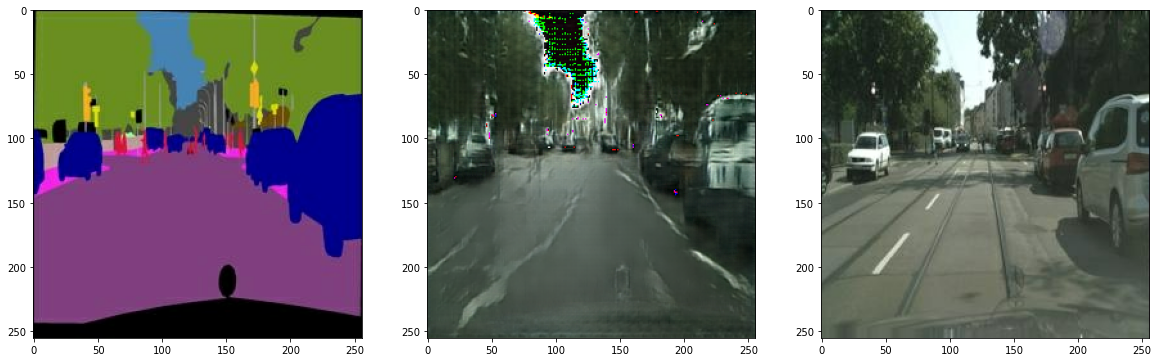

In [26]:
test_ind = 1

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
f = data_path + os.listdir(data_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 여러 미이지에 적용해보기
* 여러 모델에 대해 적용해 보았다.
* epoch 150번을 돌렸을 때, 다른 이미지들도 하늘 부분의 이미지는 아직 학습이 잘 되지 않았다.

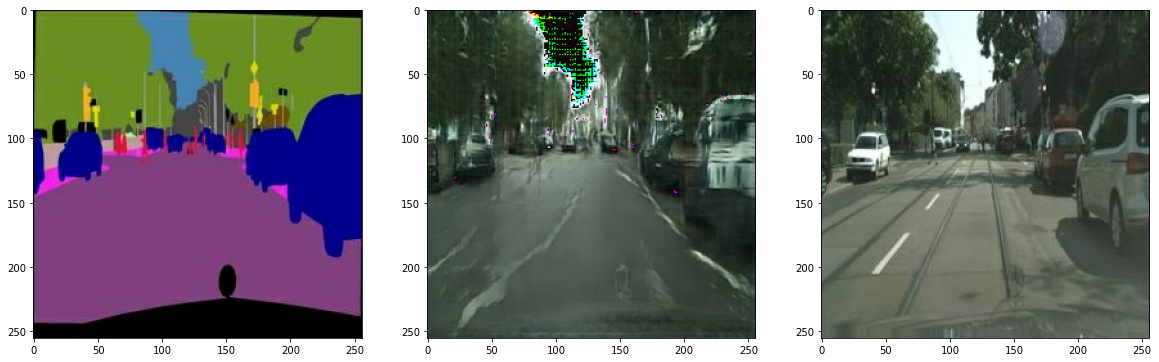

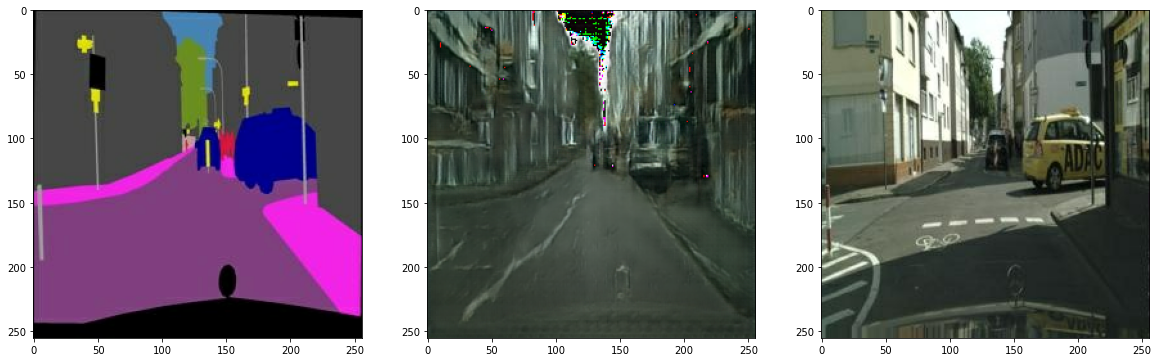

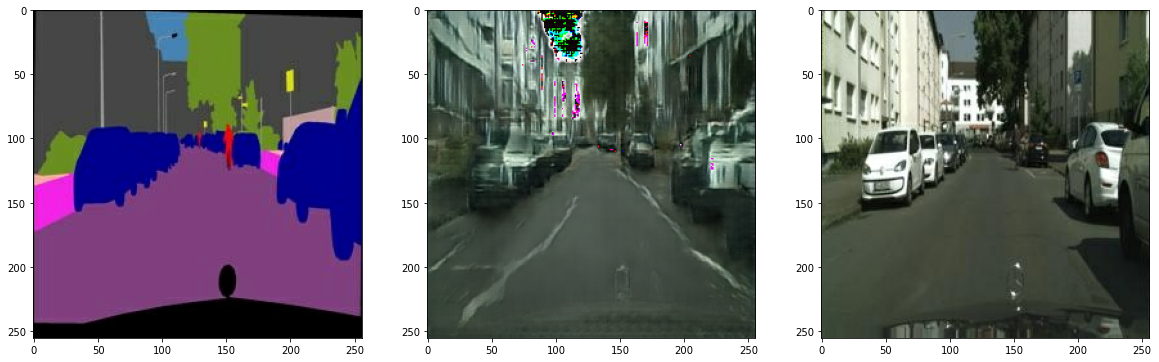

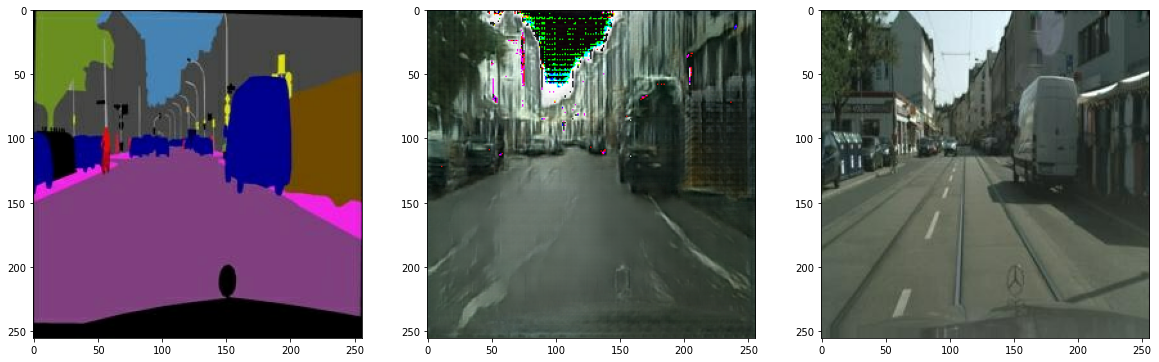

In [27]:
for i in range( 1,5):
    #test_ind = 1

    data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
    f = data_path + os.listdir(data_path)[i]
    colored, sketch = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))